# Chatbot


#### Google Drive connection

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Chatbot

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1hPqs1D4Hso-StY_HNP2-oxkXc32g02TF/Chatbot


In [2]:
import sys
import tensorflow as tf
import random

tf.random.set_seed(1234)
AUTO = tf.data.experimental.AUTOTUNE

import tensorflow_datasets as tfds
import os
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical 

print("Tensorflow version {}".format(tf.__version__))

Tensorflow version 2.8.2


#### GPU / TPU initialization


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


#### Cleaning sentence

In [4]:
def clean_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # removing contractions
  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r"he's", "he is", sentence)
  sentence = re.sub(r"she's", "she is", sentence)
  sentence = re.sub(r"it's", "it is", sentence)
  sentence = re.sub(r"that's", "that is", sentence)
  sentence = re.sub(r"there's", "there is", sentence)
  sentence = re.sub(r"'til", "until", sentence)
  sentence = re.sub(r"what's", "that is", sentence)
  sentence = re.sub(r"where's", "where is", sentence)
  sentence = re.sub(r"how's", "how is", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "cannot", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"n'", "ng", sentence)
  sentence = re.sub(r"'bout", "about", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", sentence)
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

##Prepare Dataset

We are using movies conversation data provided by [Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html), which contains more than 220 thousands conversational exchanges between more than 10k pairs of movie characters, as our dataset.

`movie_conversations.txt` contains list of the conversation IDs and `movie_lines.text` contains the text of assoicated with each conversation ID.


In [5]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

9928704/9916637 [==============================] - 2s 0us/step


### Load and preprocess data
Extracting conversation pairs into list of questions and answers preprocessing them.



In [6]:
def load_conversations():
  # dictionary of line id to text
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  pairs = [] #Question, Answer
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    # get conversation in a list of line ID
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]  #here [1: -1] is used to remove [,],' from str. Ex: ['L22', 'L33']
    for i in range(len(conversation) - 1):
      qus = clean_sentence(id2line[conversation[i]])
      ans = clean_sentence(id2line[conversation[i + 1]])
      pairs.append([qus, ans])
  return pairs
 
pairs = load_conversations()

#### Printing some samples

In [7]:
print('Q:', pairs[0][0])
print('A:', pairs[0][1])
print()  
print('Q:', pairs[1][0])
print('A:', pairs[1][1])
print()
print('Total pairs:', len(pairs))

Q: can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again
A: well i thought we would start with pronunciation if that is okay with you

Q: well i thought we would start with pronunciation if that is okay with you
A: not the hacking and gagging and spitting part please

Total pairs: 221616


#### Defining maximum sentence length

In [8]:
# finding the maximum length of questions and answers
# because there are senteces with unusually long lengths, we caculate the max length that 80% of data can be placed in

percentage = 80
ques = []
ans = []
for i in pairs:
    ques.append(i[0])
    ans.append(i[1])
    
length_questions = list(len(q.split()) for q in ques)
length_answers = list(len(a.split()) for a in ans)
max_len_q, max_len_a = int(np.percentile(length_questions, percentage)),int(np.percentile(length_answers, percentage))
max_len = max(max_len_q, max_len_a)

print('maximum length of %d conversation is %d' %(percentage, max_len))

maximum length of 80 conversation is 16


#### Filtering conversations using max_len threshold

In [9]:
# Remove questions and answers that are longer than maxlen.
ques_filtered = []
ans_filtered = []
for q, a in zip(ques, ans):
    if (len(q.split()) <= max_len and len(a.split()) <= max_len):    
        ques_filtered.append(q)
        ans_filtered.append(a)

print('Filtered questions lengths:', len(ques_filtered))

Filtered questions lengths: 145073


In [10]:
print(ques_filtered[0])
print(ans_filtered[0])

well i thought we would start with pronunciation if that is okay with you
not the hacking and gagging and spitting part please


#### Fitting keras tokenizer on conversational dataset

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(ques_filtered+ans_filtered)

idx2word = {} # index to word dic
word2idx = tokenizer.word_index # word to index dict

for w in tokenizer.word_index:
    idx2word[tokenizer.word_index[w]] = w

start_token, end_token = [len(tokenizer.word_index)], [len(tokenizer.word_index) + 1]

# Vocabulary size plus start and end token. additional one for embedding layer
vocab_size = len(tokenizer.word_index) + 3
print('Vocabulary size:', vocab_size)

Vocabulary size: 35894


#### Storing tokenizer object

In [12]:
#import pickle
#with open('tokenizer.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

#### Tokenizing and subsequently padding conversations

In [13]:
# Tokenize, filter and pad sentences
def tokenize_texts(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = start_token + tokenizer.texts_to_sequences([sentence1])[0] + end_token
    sentence2 = start_token + tokenizer.texts_to_sequences([sentence2])[0] + end_token
    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=max_len, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=max_len, padding='post')
  
  return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_texts(ques_filtered, ans_filtered)

#### Defining hyperparameters for transformer model

In [14]:
# For tf.data.Dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 100 #D_MODEL should match with embedding dimension
NUM_HEADS = 5 #D_MODEL/NUM_HEADS must be integer
UNITS = 512
DROPOUT = 0.1

## Embedding Layer
#### This layer includes pretrained GloVe embedding matrix

In [15]:
 # Making the embedding mtrix
def make_embedding_layer(embedding_dim=100, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        glove_dir = 'GloVe/'
        embeddings_index = {} 
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ",embedding_dim, ' loded!')
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in word2idx.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
    
    # we have a limited vocab so we do not train the embedding layer we use 0 as padding so => mask_zero=True
    embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False) 
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

#### Creating Dataset for Transformer

We are going to use the [tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data) to contruct our input pipline in order to utilize features like caching and prefetching to speed up the training process.


In [16]:
# decoder inputs use the previous target as input
# remove start_token from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Attention



### Scaled dot product Attention

The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$${Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$



In [17]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)
  output = tf.matmul(attention_weights, value)

  return output

### Multi-head attention

Multi-head attention consists of four parts:
* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.


In [18]:
class MultiHeadedAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadedAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)
    self.dense = tf.keras.layers.Dense(units=d_model)
  
  def get_config(self):
        config = super(MultiHeadedAttention,self).get_config()
        config.update({
            'num_heads':self.num_heads,
            'd_model':self.d_model,
        })
        return config

  def split_heads(self, inputs, batch_size):
    inputs = tf.keras.layers.Lambda(lambda inputs:tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)))(inputs)
    return tf.keras.layers.Lambda(lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3]))(inputs)

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.transpose(
        scaled_attention, perm=[0, 2, 1, 3]))(scaled_attention)

    # concatenation of heads
    concat_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model)))(scaled_attention)

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

## Transformer

### Masking



`create_padding_mask` and `create_look_ahead` are helper functions to create masks to mask out padded tokens, we are going to use these helper functions as `tf.keras.layers.Lambda` layers.

Mask all the pad tokens (value `0`) in the batch to ensure the model does not treat padding as input.

In [19]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

In [20]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### Positional encoding

Positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The formula for calculating the positional encoding is as follows:

$${PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$${PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [21]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)
    self.position = position
    self.d_model = d_model
  
  def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model,
            
        })
        return config

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

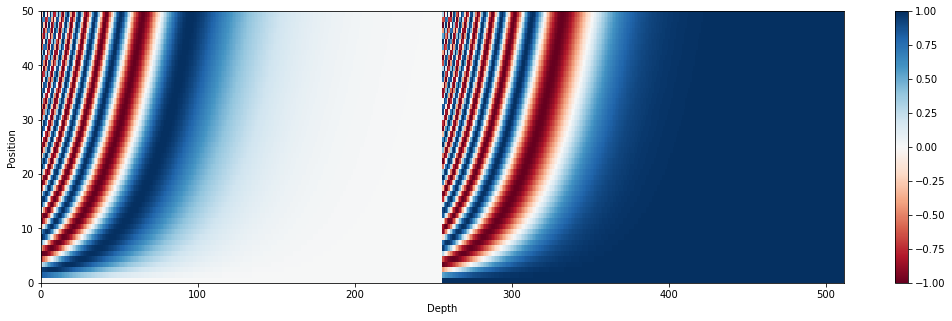

In [25]:
plt.figure(figsize=(18,5))

sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Encoder Layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask) 
2. 2 dense layers followed by dropout

In [26]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadedAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  add_attention = tf.keras.layers.add([inputs,attention])
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([attention,outputs])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Encoder

The Encoder consists of:
1.   Input Embedding
2.   Positional Encoding
3.   `num_layers` encoder layers


In [27]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = make_embedding_layer(embedding_dim=D_MODEL, glove=True)(inputs)
  embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
  embeddings = PositionalEncoding(vocab_size,d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout


In [28]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadedAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  add_attention = tf.keras.layers.add([attention1,inputs])    
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  attention2 = MultiHeadedAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  add_attention = tf.keras.layers.add([attention2,attention1])
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([outputs,attention2])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

In [29]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = make_embedding_layer(embedding_dim=D_MODEL, glove=True)(inputs)
  embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [30]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
      )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
      )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## Train model

### Loss function


In [31]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = tf.constant(d_model,dtype=tf.float32)
    self.warmup_steps = warmup_steps
    
  def get_config(self):
        return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.multiply(tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2))

Text(0.5, 0, 'Train Step')

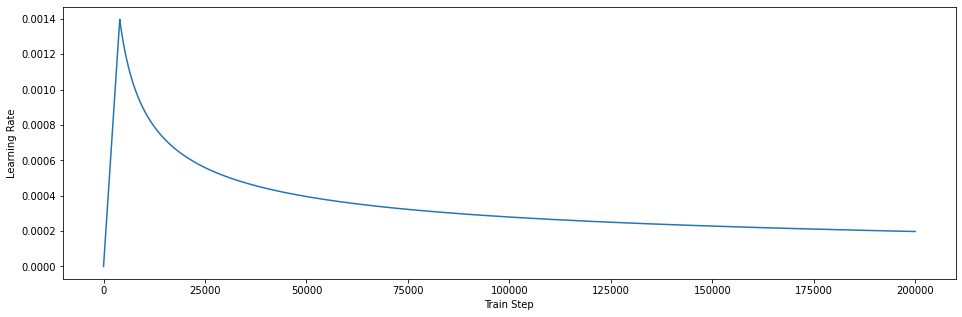

In [33]:
plt.figure(figsize=(16, 5))
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Initialize and compile model

Initialize and compile model with our predefined custom learning rate and Adam optimizer under the strategy scope.

In [34]:
from tensorflow import keras
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, max_len_q - 1)
  y_true = tf.reshape(y_true, shape=(-1, max_len_q - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

with strategy.scope():
  model = transformer(
      vocab_size=vocab_size,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT)
  print('Created new model')

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model.summary()

Loading glove...
GloVe  100  loded!
Loading glove...
GloVe  100  loded!
Created new model
Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 100)    3877024     ['inputs[0][0]',                

#### Save empty model

In [36]:
model.save('chatbotEmpty.tf', include_optimizer=False)

#### Fit *model*
Use TPU for faster trainning

In [106]:
model.fit(dataset, epochs=50)

Epoch 1/50
284/284 [==============================] - 16s 56ms/step - loss: 1.7780 - accuracy: 0.1474
Epoch 2/50
284/284 [==============================] - 16s 55ms/step - loss: 1.7769 - accuracy: 0.1477
Epoch 3/50
284/284 [==============================] - 16s 55ms/step - loss: 1.7767 - accuracy: 0.1475
Epoch 4/50
284/284 [==============================] - 16s 57ms/step - loss: 1.7768 - accuracy: 0.1476
Epoch 5/50
284/284 [==============================] - 16s 57ms/step - loss: 1.7766 - accuracy: 0.1474
Epoch 6/50
284/284 [==============================] - 16s 57ms/step - loss: 1.7758 - accuracy: 0.1475
Epoch 7/50
284/284 [==============================] - 16s 56ms/step - loss: 1.7760 - accuracy: 0.1476
Epoch 8/50
284/284 [==============================] - 16s 55ms/step - loss: 1.7765 - accuracy: 0.1477
Epoch 9/50
284/284 [==============================] - 16s 55ms/step - loss: 1.7758 - accuracy: 0.1478
Epoch 10/50
284/284 [==============================] - 16s 55ms/step - loss: 1.775

In [110]:
model.save_weights('chatbotWeights.h5')

#### Load Trained model

In [38]:
model = keras.models.load_model('chatbotEmpty.tf')
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
#trained 300epochs
model.load_weights('chatbotWeights.h5')

## Evaluate and predict

The following steps are used for evaluation:

* Apply the same preprocessing method we used to create our dataset for the input sentence.
* Tokenize the input sentence and add `START_TOKEN` and `END_TOKEN`. 
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output.
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.


In [122]:
def evaluate(sentence):
  sentence = clean_sentence(sentence)

  sentence = tf.expand_dims(start_token + tokenizer.texts_to_sequences([sentence])[0] + end_token, axis=0)
  output = tf.expand_dims(start_token, 0)

  for i in range(max_len):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    maxid = tf.argmax(predictions, axis=-1) 

    if maxid == end_token: 
      selected = maxid
    else:  #beam search with beamwidth = 3
      candidates = tf.argsort(predictions, axis=-1, direction='ASCENDING')[:,:,-3:] #select three maximum candidate words
      selected = random.choice(np.squeeze(candidates)) #randomly choice one word
      selected = np.expand_dims(np.expand_dims(selected, axis=0), axis=0) #expand dims [[value]]

    predicted_id = tf.cast(selected, tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, end_token[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)
  tokens = [p for p in prediction.numpy() if p < vocab_size and p != start_token and p != end_token]
  predicted_sentence = tokenizer.sequences_to_texts([tokens])[0]
  return predicted_sentence

#### Testing trained model

In [126]:
output = predict("how are you?")
print(output)

i am doing okay


In [127]:
output = predict('Where have you been?')
print(output)

just around the corner
